# How to fit Zeta Phe with `starry`

In [1]:
# This lets us change the eb.py file and run the notebook simultaenously,
# without having to reload the notebook every time!
% load_ext autoreload
% autoreload 2

### ζ Phe Aa
* Mass	3.92 M☉
* Radius	2.85 R☉
* Luminosity	316 L☉
* Surface gravity (log g)	4.12 cgs
* Temperature	14,400 K


### ζ Phe Ab
* Mass	2.55 M☉
* Radius	1.85 R☉
* Luminosity	65 L☉
* Surface gravity (log g)	4.31 cgs
* Temperature	12,000 K


* ecc 0.0113
* omega 13 degrees


**TESS Quadratic Limb Darkening**:

* Primary (14000K, logg 4, Fe_H 0, xi 0): a: 0.1044, b: 0.2248
* Secondary (12000, logg 4.5, Fe_H 0, xi 0): a: 0.1253, b: 0.2357

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm
import pandas as pd

from scipy.optimize import minimize

import lightkurve as lk
import chromo
from chromo import eb
from chromo.utils import background_correct
import starry


In [32]:
plt.style.use(lk.MPLSTYLE)

'/Users/ch/Hacks/TESSparty/chromo/chromo'

In [40]:
tess_bandpass = pd.read_csv('{}/data/tess-response-function-v1.0.csv'.format(chromo.PACKAGEDIR), comment='#', header=None)

In [3]:
def ellipsoidal_variation(A_1, A_2, phase, phase2):
    return A_1 * np.cos(4 * np.pi * phase) + A_2 * np.cos(2 * np.pi * phase2)

In [4]:
period, t0 = 1.6695564535964362, 0.7686931840715678

In [137]:
tpf = background_correct(lk.search_tesscut('Zet Phe').download(cutout_size=[30, 30]))

/Users/ch/Hacks/TESSparty/chromo/chromo/utils.py:86: RuntimeWarning: invalid value encountered in greater
  mask = thumb > np.nanpercentile(thumb, 5)


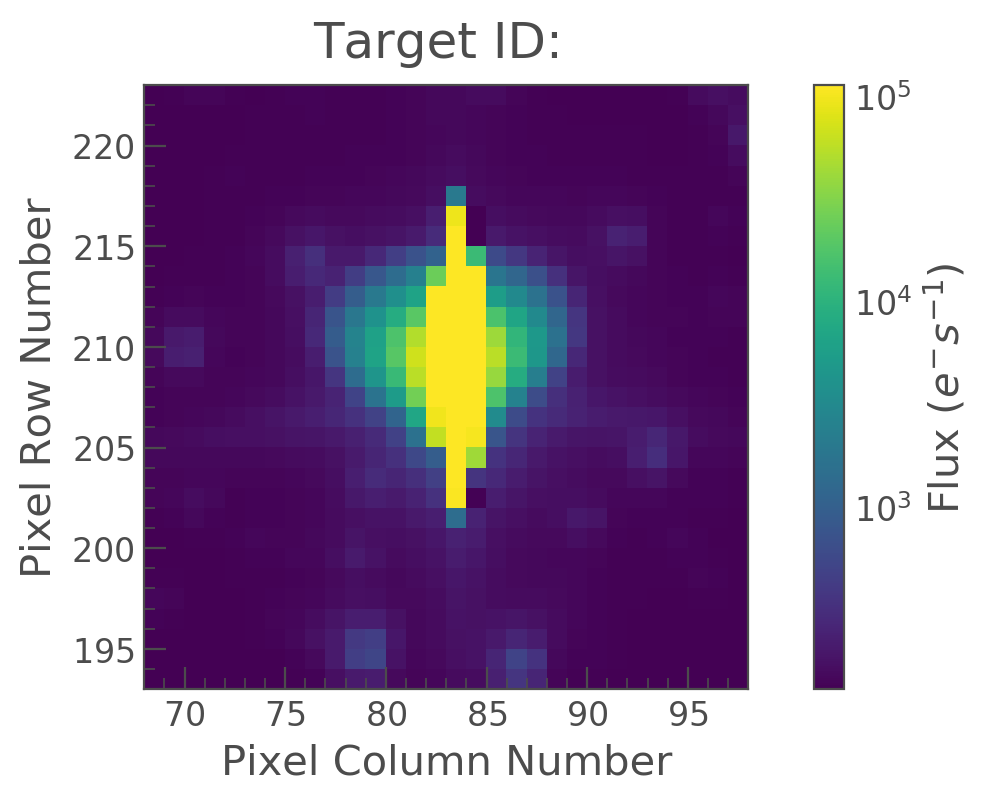

In [138]:
tpf.plot(scale='log')

In [139]:
lc = tpf.to_lightcurve().normalize()
nb = 100
x_fold = (lc.time - t0 - period/2) / period % 1 - 0.5
x_fold_2 = np.copy(x_fold) + 0.5
x_fold_2[x_fold > 0] -= 1
k = (np.abs(x_fold) > 0.1) & (np.abs(x_fold) < 0.4)

inds = np.array_split(np.argsort(x_fold), np.linspace(0, len(x_fold), nb + 1, dtype=int))[1:-1]
x_fold_b = np.asarray([np.median(x_fold[ind]) for ind in inds])
flux_b = np.asarray([np.median(lc.flux[ind]) for ind in inds])
flux_b /= np.nanmedian(lc.flux)

func = interp1d(x_fold_b[np.argsort(x_fold_b)], flux_b[np.argsort(x_fold_b)],
                kind='cubic', fill_value='extrapolate')
eb_model = func(x_fold)
lc /= chromo.utils.poly_detrend(lc, eb_model).flux

/Users/ch/Hacks/TESSparty/chromo/chromo/utils.py:86: RuntimeWarning: invalid value encountered in greater
  mask = thumb > np.nanpercentile(thumb, 5)
Calculating Pixel Light Curves: 100%|██████████| 30/30 [00:03<00:00,  9.29it/s]
/Users/ch/Hacks/TESSparty/chromo/chromo/eb.py:131: RuntimeWarning: divide by zero encountered in log10
  aper &= np.log10(score) < -300
/Users/ch/Hacks/TESSparty/chromo/chromo/utils.py:220: RuntimeWarning: divide by zero encountered in true_divide
  im = ax.imshow(secondary_depth_resid/(aper), cmap=cmap, norm=norm)


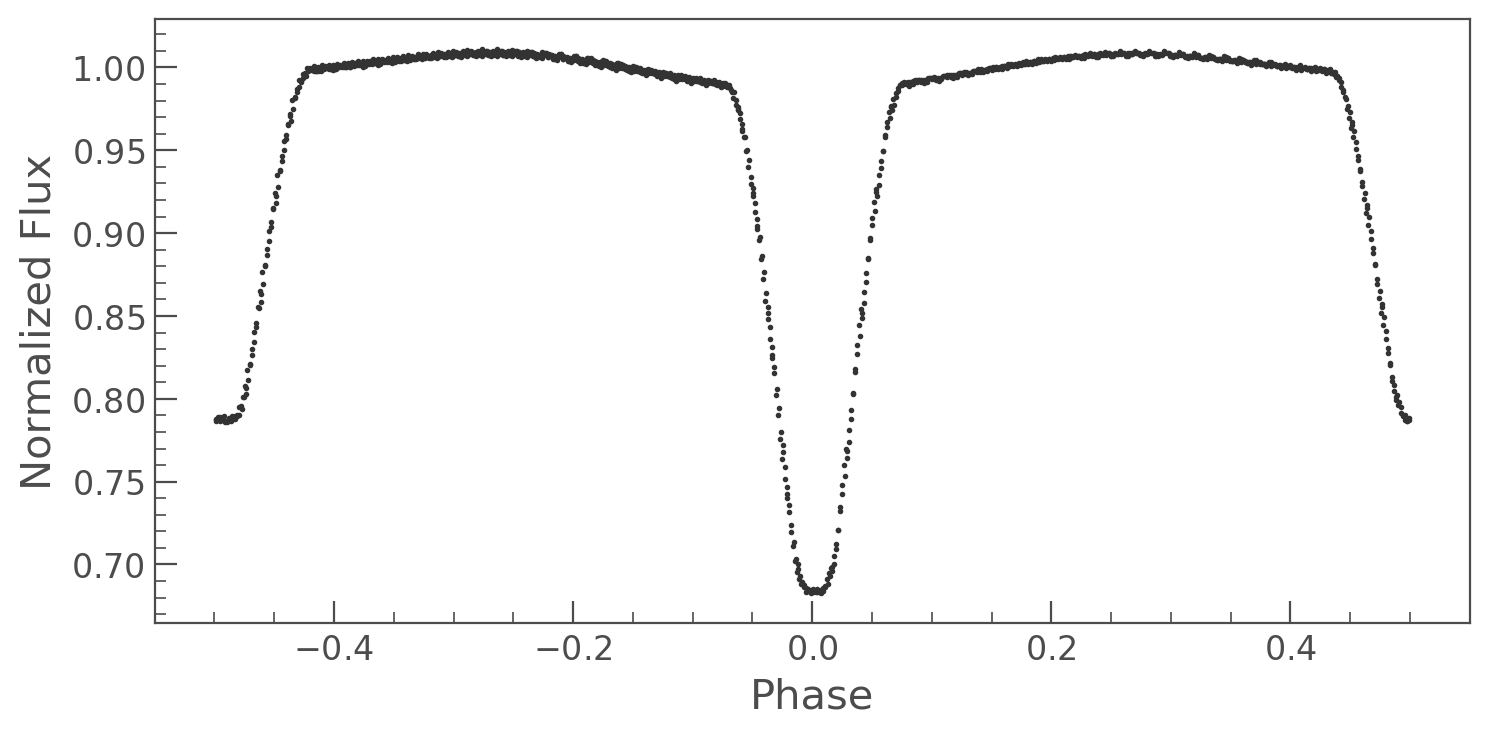

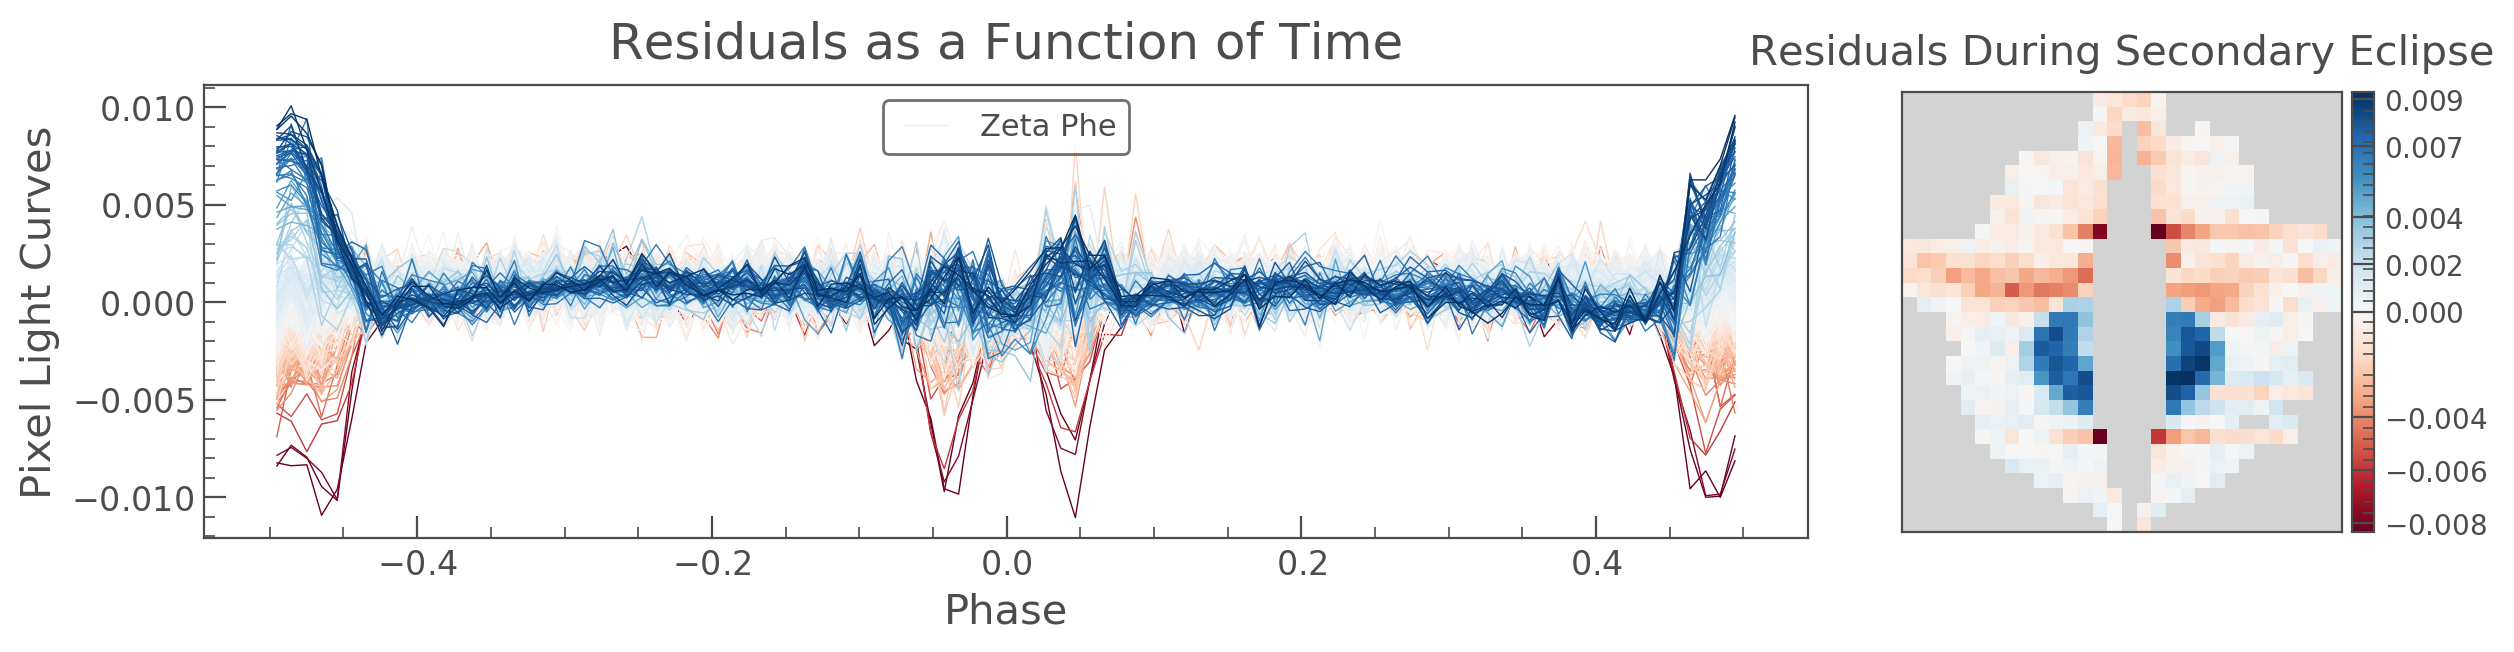

In [140]:
data, error, model, normalization, aper = eb.analyze(tpf, period, t0, 'Zeta Phe')
corr = np.atleast_3d(1/normalization).transpose([2, 0, 1])
data = data * corr - corr + 1

In [141]:
aper[0,0] = False
aper[0, -1] = False

In [142]:
primary = starry.kepler.Primary(lmax=2)
secondary = starry.kepler.Secondary(lmax=2)
system = starry.kepler.System(primary, secondary)

In [188]:
def likelihood(params, lc, save_params=False, return_model=False): 
    
    system.secondaries[0].r = params[0]
    system.secondaries[0].L = params[1]

    
    if (len(params) > 2):        
        ev = ellipsoidal_variation(params[2], params[3], x_fold + 0.5, x_fold_2 + 0.5)

#        system.primary[1] = params[4]
#        system.primary[2] = params[5]
#        system.secondaries[0][1] = params[6]
#        system.secondaries[0][2] = params[7]


        system.secondaries[0].tref = params[8]
        system.secondaries[0].porb = params[9]
        system.secondaries[0].inc = params[10]
        system.secondaries[0].w = params[11]
        system.secondaries[0].ecc = params[12]
        system.secondaries[0].a = params[13]
    
    else:
        ev = ellipsoidal_variation(result.x[2], result.x[3], x_fold + 0.5, x_fold_2 + 0.5)


    if save_params:
        saved_params.append(params)
    system.compute(lc.time)
    model = system.lightcurve/np.median(system.lightcurve[k]) + ev
    if return_model:
        return model
    
    chi = (1/len(lc.flux)) * np.sum((lc.flux - model)**2/(lc.flux_err**2))
    return chi

In [189]:
labels = ['radius', 'L', 'ellipsoidal amplitude', 'reflection_amplitude',
          'primary_u_0', 'primary_u_1', 'secondary_u_0', 'secondary_u_1',
          'tref', 'period', 'inclination', 'omega', 'eccentricity', 'a']

init = [1.85/2.85, 65/316, -0.01, -0.005,
        0.1044, 0.2248, 0.1253, 0.2357,
        t0, period, 84, 13, 0.0113, 3.5]

bounds = [(0.3, 0.9), (0.05, 0.5), (-0.03, 0), (-0.03, 0),
          (0, 1), (0, 1), (0, 1), (0, 1),
         (t0 - 0.01, t0 + 0.01), (period - 0.02, period + 0.02), (0, 90), (0, 30), (0, 0.02), (2, 5)]

In [190]:
#labels = ['tref', 'radius', 'L', 'a', 'primary_u_0', 'primary_u_1', 'secondary_u_0',
#          'secondary_u_1', 'eccentricity', 'omega', 'ellipsoidal amplitude', 'period', 'inclination', 'reflection_amplitude']
#init = [t0, 1.85/2.85, 65/316, 3.5, 0.4, 0.2, 0.4, 0.2, 0.0113, 13, -0.01, period, 90, -0.005]
#bounds = [(t0 - 0.01, t0 + 0.01), (0.3, 0.9), (0.05, 0.5), (2, 5),
#          (0, 1), (0, 1), (0, 1), (0, 1), (0, 0.02), (0, 30), (-0.03, 0), (period - 0.02, period + 0.02), (0, 180), (-0.03, 0)]

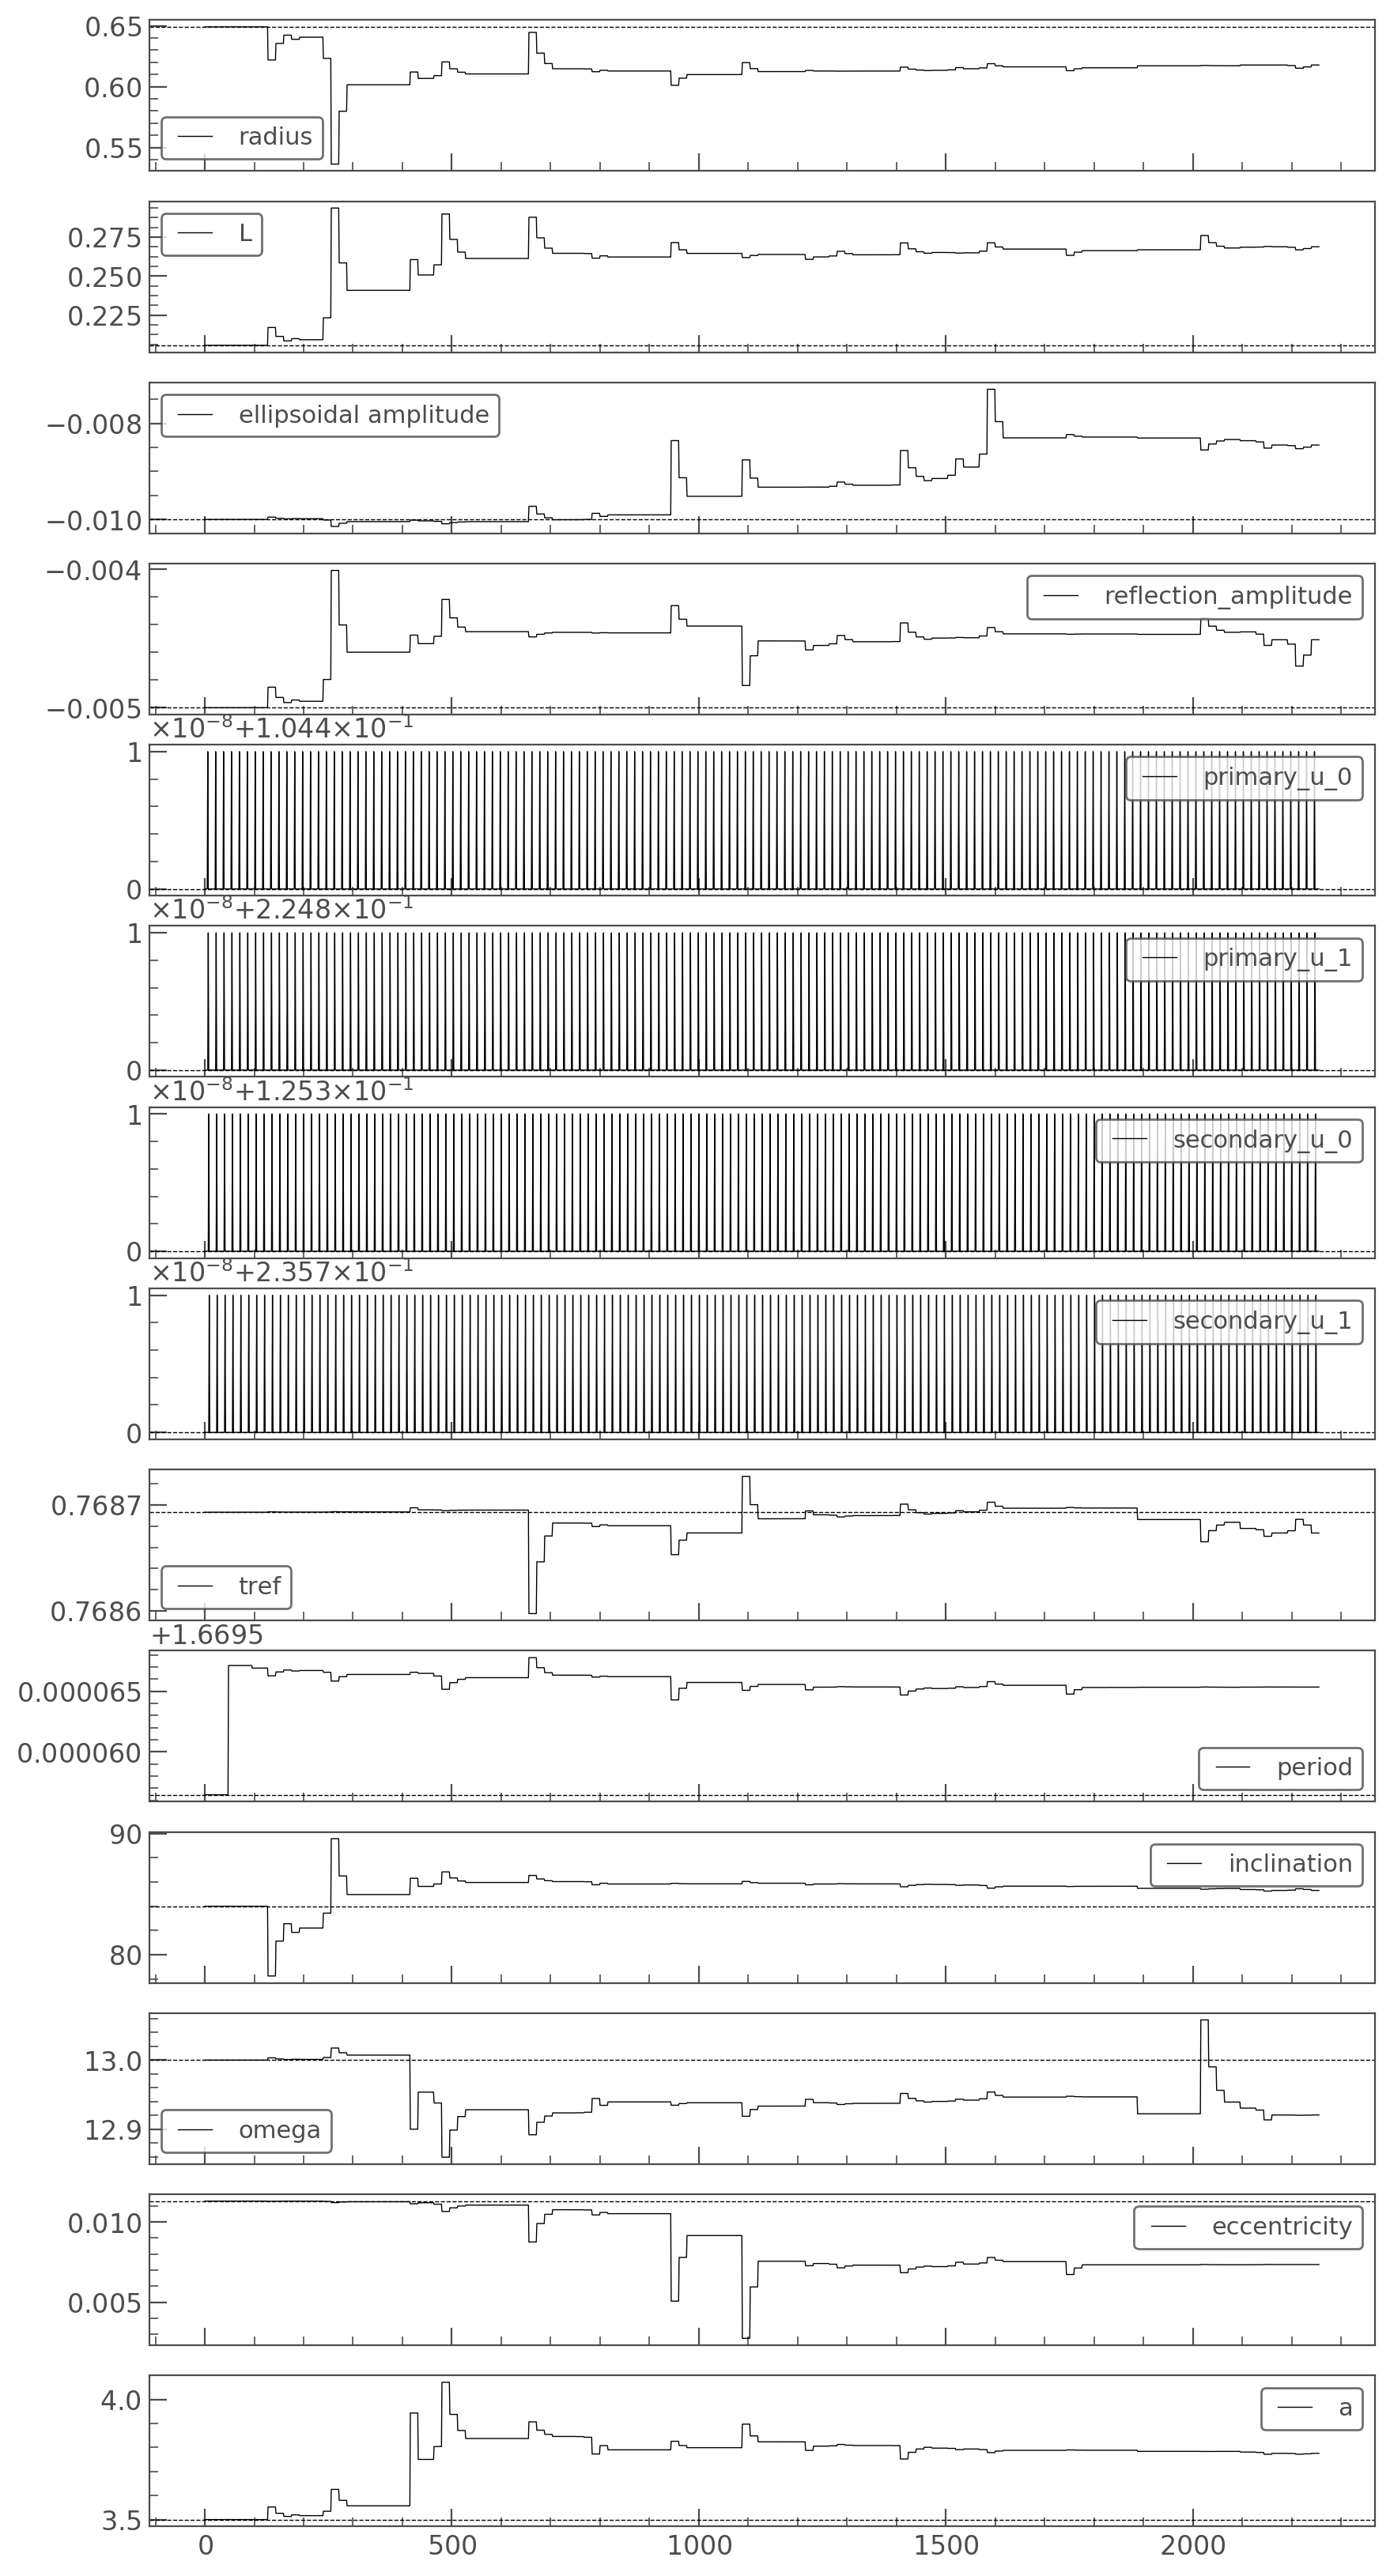

In [191]:
saved_params = []

_ = likelihood(init, lc)
result = minimize(likelihood, init, method='TNC', bounds=bounds, args=(lc, True))

fig, axs = plt.subplots(len(init), 1, figsize=(10, 1.5 * len(init)), sharex=True)
for idx, parameter, initial_guess, label in zip(range(len(init)), np.asarray(saved_params).T, init, labels):
    axs[idx].plot(parameter, label=label, c='k');
    axs[idx].axhline(initial_guess, color='k', ls='--')
    axs[idx].legend()
saved_params = []

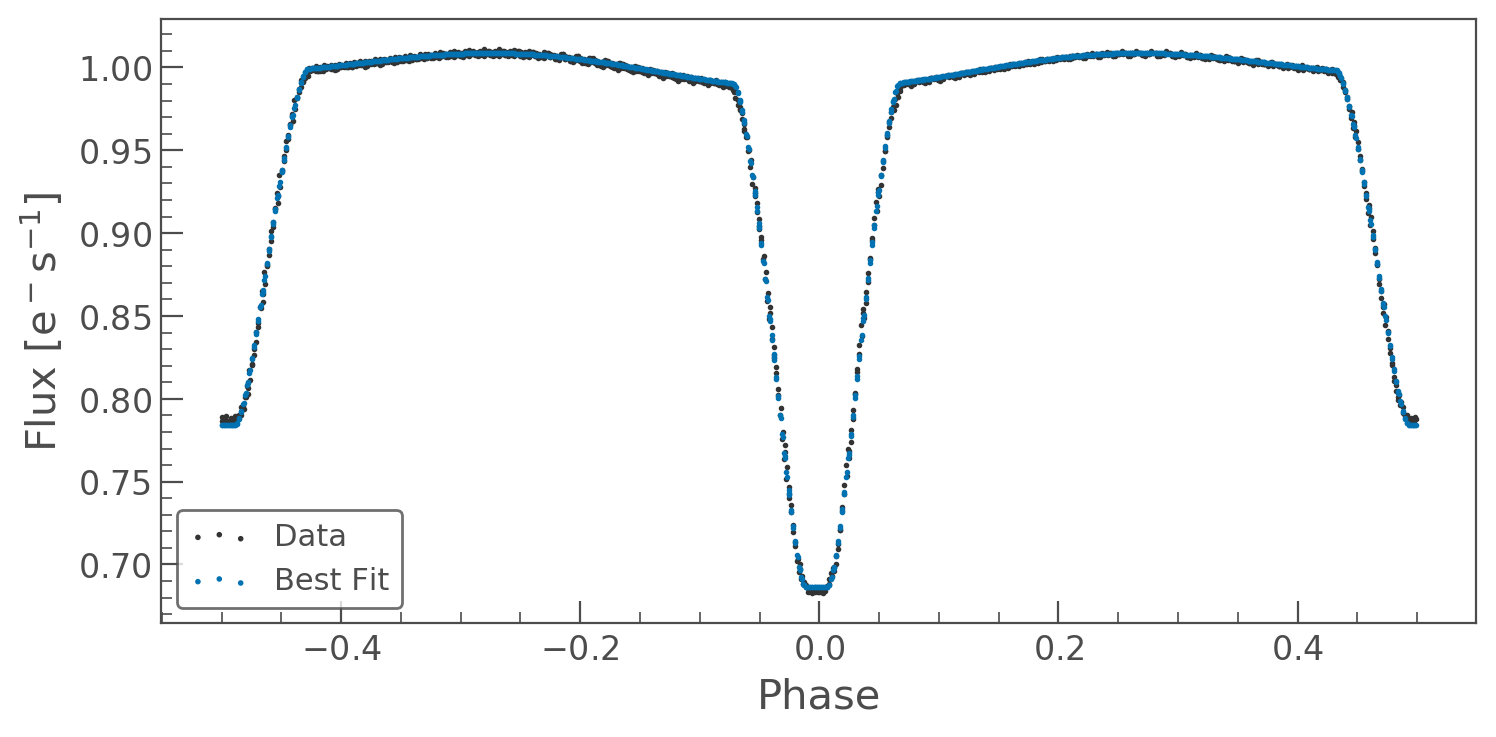

In [192]:
ax = lc.fold(result.x[9], result.x[8]).scatter(normalize=False, label='Data')
lk.LightCurve(lc.time, likelihood(result.x, lc, return_model=True)).fold(result.x[9], result.x[8]).scatter(normalize=False, ax=ax, label='Best Fit')

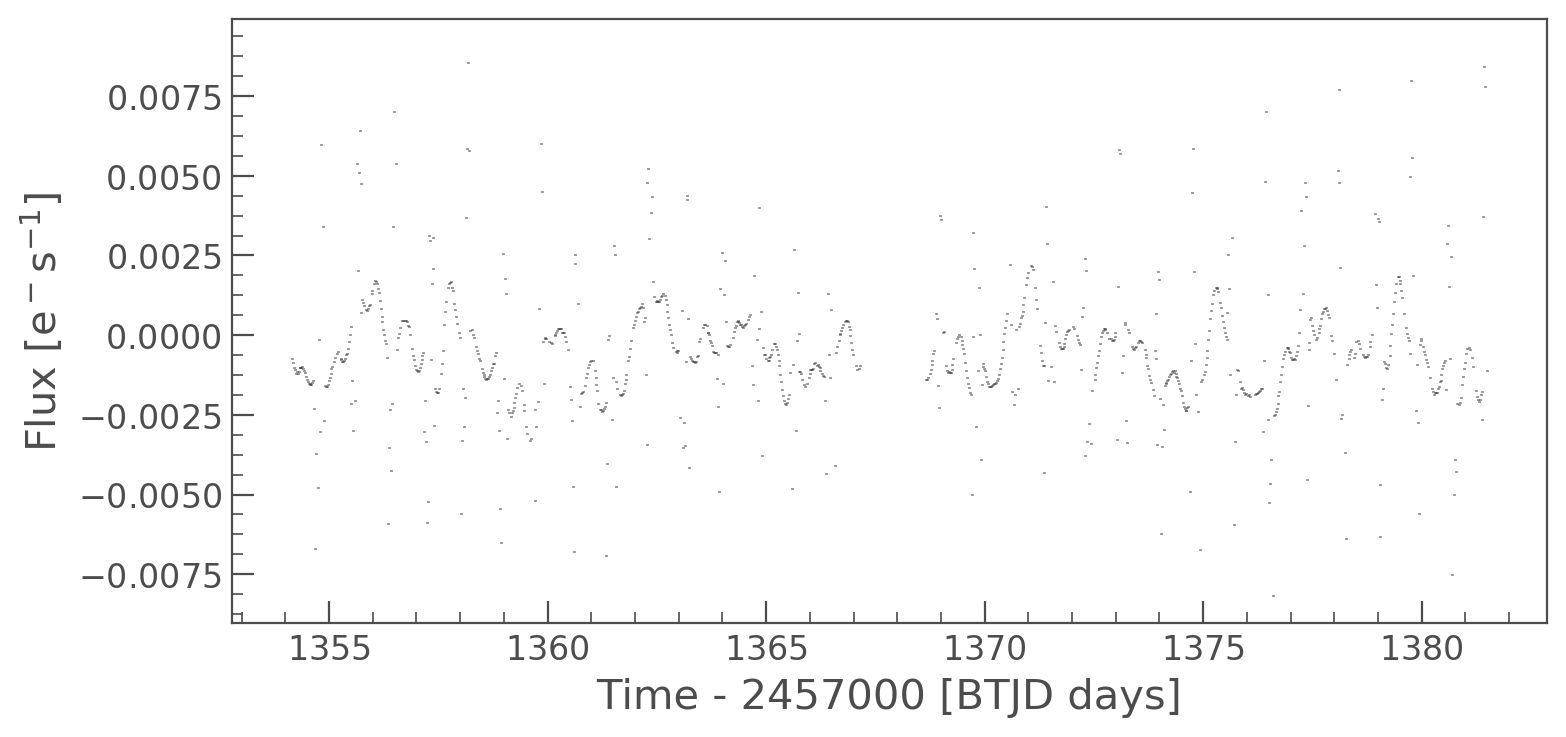

In [193]:
(lc - likelihood(result.x, lc, return_model=True)).errorbar(normalize=False, lw=1)

In [194]:
init = init[:2]
labels = labels[:2]
bounds = bounds[:2]

In [195]:
labels

['radius', 'L']

In [196]:
radius, luminosity = np.zeros(data.shape[1:]), np.zeros(data.shape[1:])
for idx in tqdm(range(data.shape[1])):
    for jdx in range(data.shape[2]):
        if not aper[idx, jdx]:
            continue
        pix_lc = lk.LightCurve(lc.time, data[:, idx, jdx], error[:, idx, jdx])
        pix_result = minimize(likelihood, init, method='TNC', bounds=bounds, args=(pix_lc, False))
        radius[idx, jdx] = pix_result.x[0]
        luminosity[idx, jdx] = pix_result.x[1]

100%|██████████| 30/30 [02:17<00:00,  4.57s/it]


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


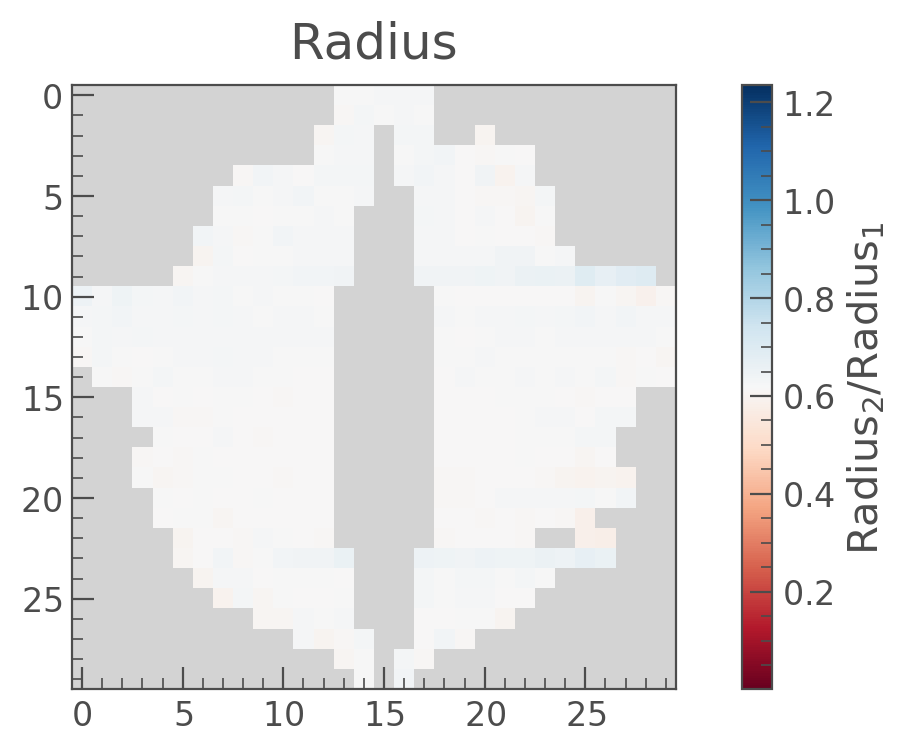

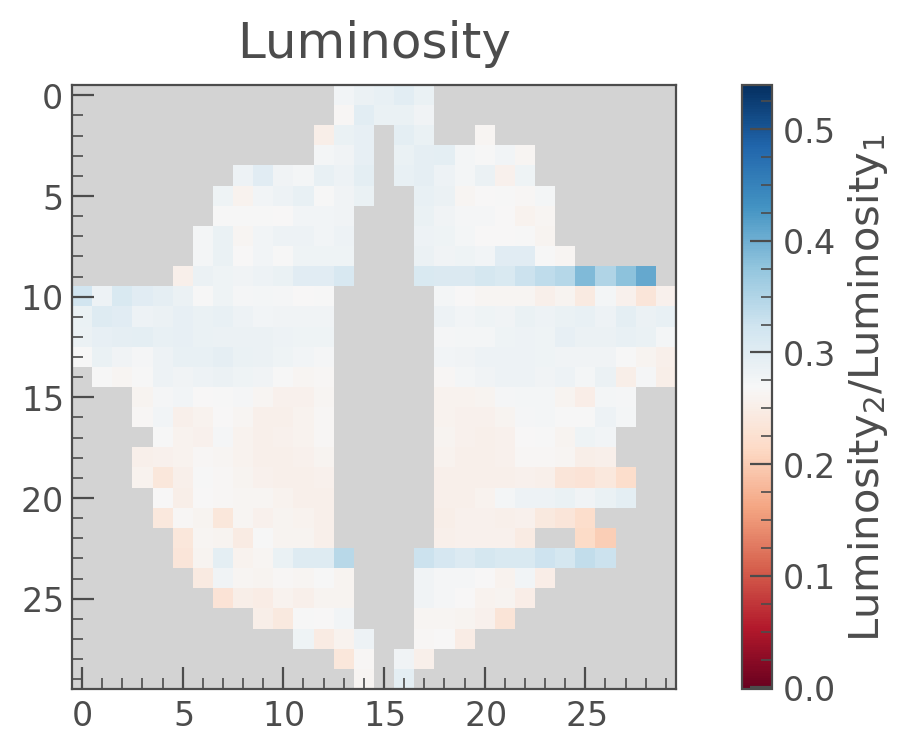

In [197]:
for idx, label, ar in zip(range(2), ['Radius', 'Luminosity'], [radius, luminosity]):
    plt.figure()
    vmin = np.nanpercentile(ar[aper] - result.x[idx], 40)
    vmax = np.nanpercentile(ar[aper] - result.x[idx], 60)
    dv = np.max(np.abs(np.asarray([result.x[idx] - vmin, vmax - result.x[idx]])), axis=0)
    
    plt.imshow(ar/aper, vmin=result.x[idx]-dv, vmax=result.x[idx]+dv, cmap='RdBu')
    cbar = plt.colorbar()
    cbar.set_label('{0}$_2$/{0}$_1$'.format(label))
    plt.title('{}'.format(label))

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


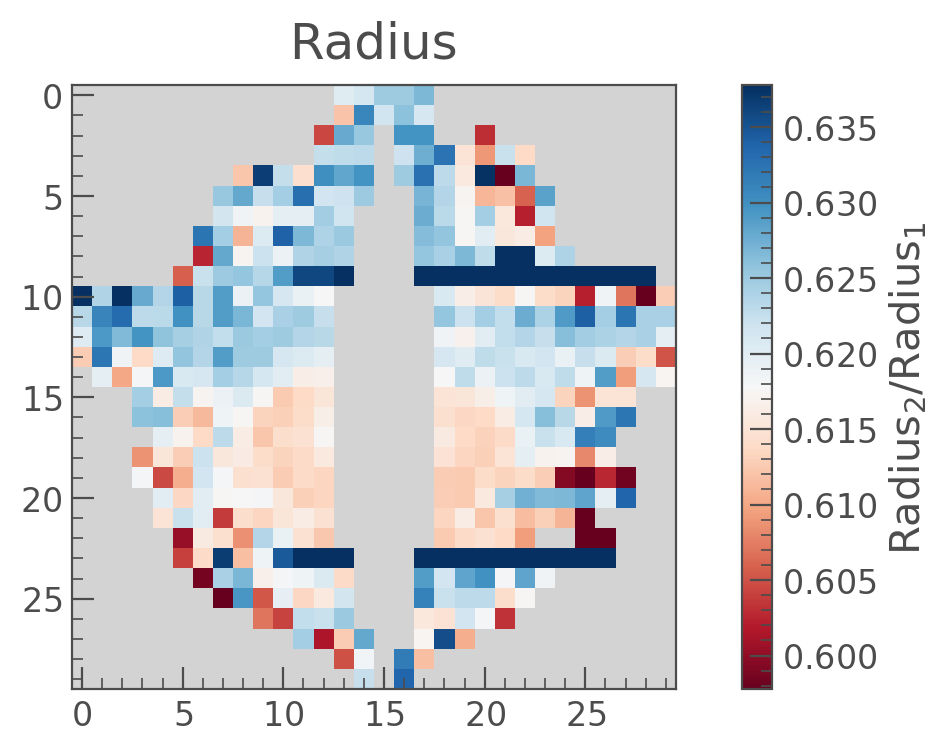

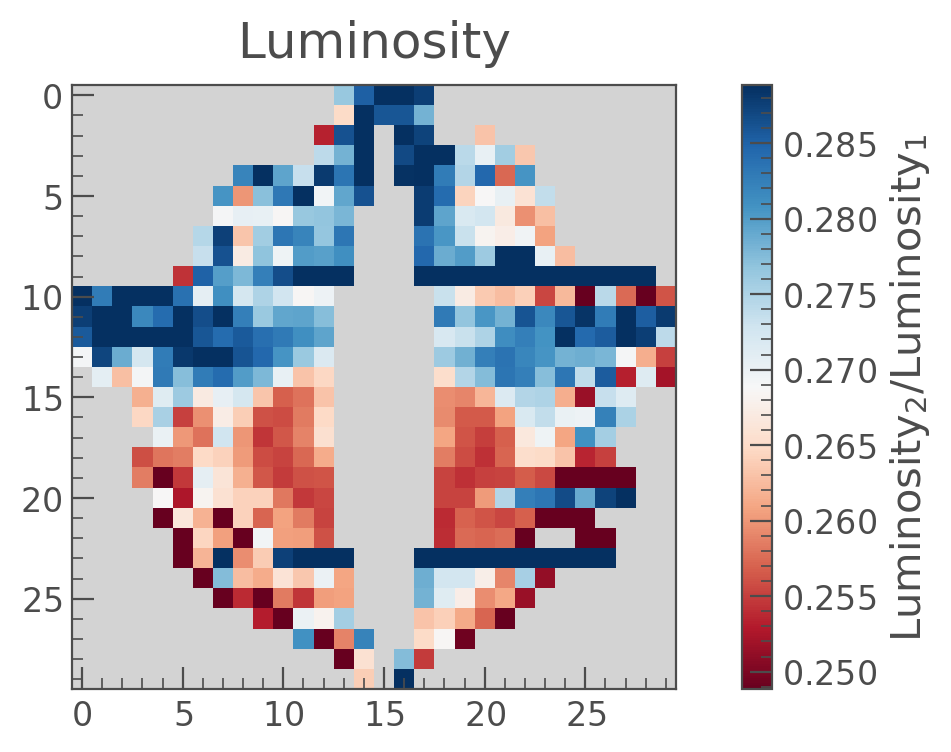

In [198]:
for idx, label, ar in zip(range(2), ['Radius', 'Luminosity'], [radius, luminosity]):
    plt.figure()
    plt.imshow(ar/aper, vmin=result.x[idx]-0.02, vmax=result.x[idx]+0.02, cmap='RdBu')
    cbar = plt.colorbar()
    cbar.set_label('{0}$_2$/{0}$_1$'.format(label))
    plt.title('{}'.format(label))

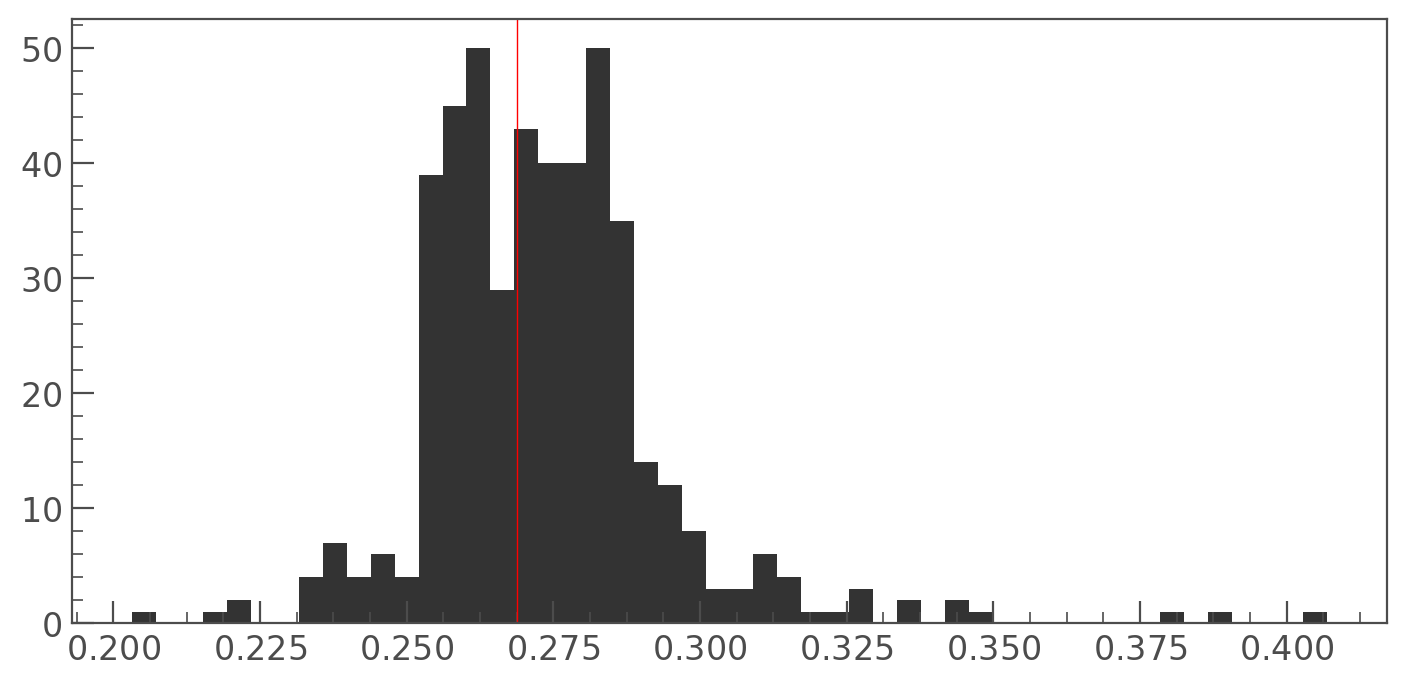

In [199]:
plt.hist(luminosity[aper], 50);
plt.axvline(result.x[1], c='r')

In [200]:
from astropy.modeling.blackbody import blackbody_lambda
from astropy.constants import sigma_sb
import astropy.units as u

In [201]:
teff1 = 14400 * u.K
teff2 = 12000 * u.K
r1 = 2.85 * u.solRad
r2 = 1.85 * u.solRad
l1 = 65 * u.solLum
l2 = 316 *u.solLum

wavelength = np.linspace(100, 1.4e4, 10000)*u.nm

In [202]:
primary_bb = blackbody_lambda(wavelength, teff1)
secondary_bb = blackbody_lambda(wavelength, teff2) * (r2/r1)**2

In [203]:
wav_func = interp1d((secondary_bb/primary_bb).value, wavelength.value, fill_value='extrapolate', kind='cubic')

Text(0.5,0,'Wavelength [nm]')

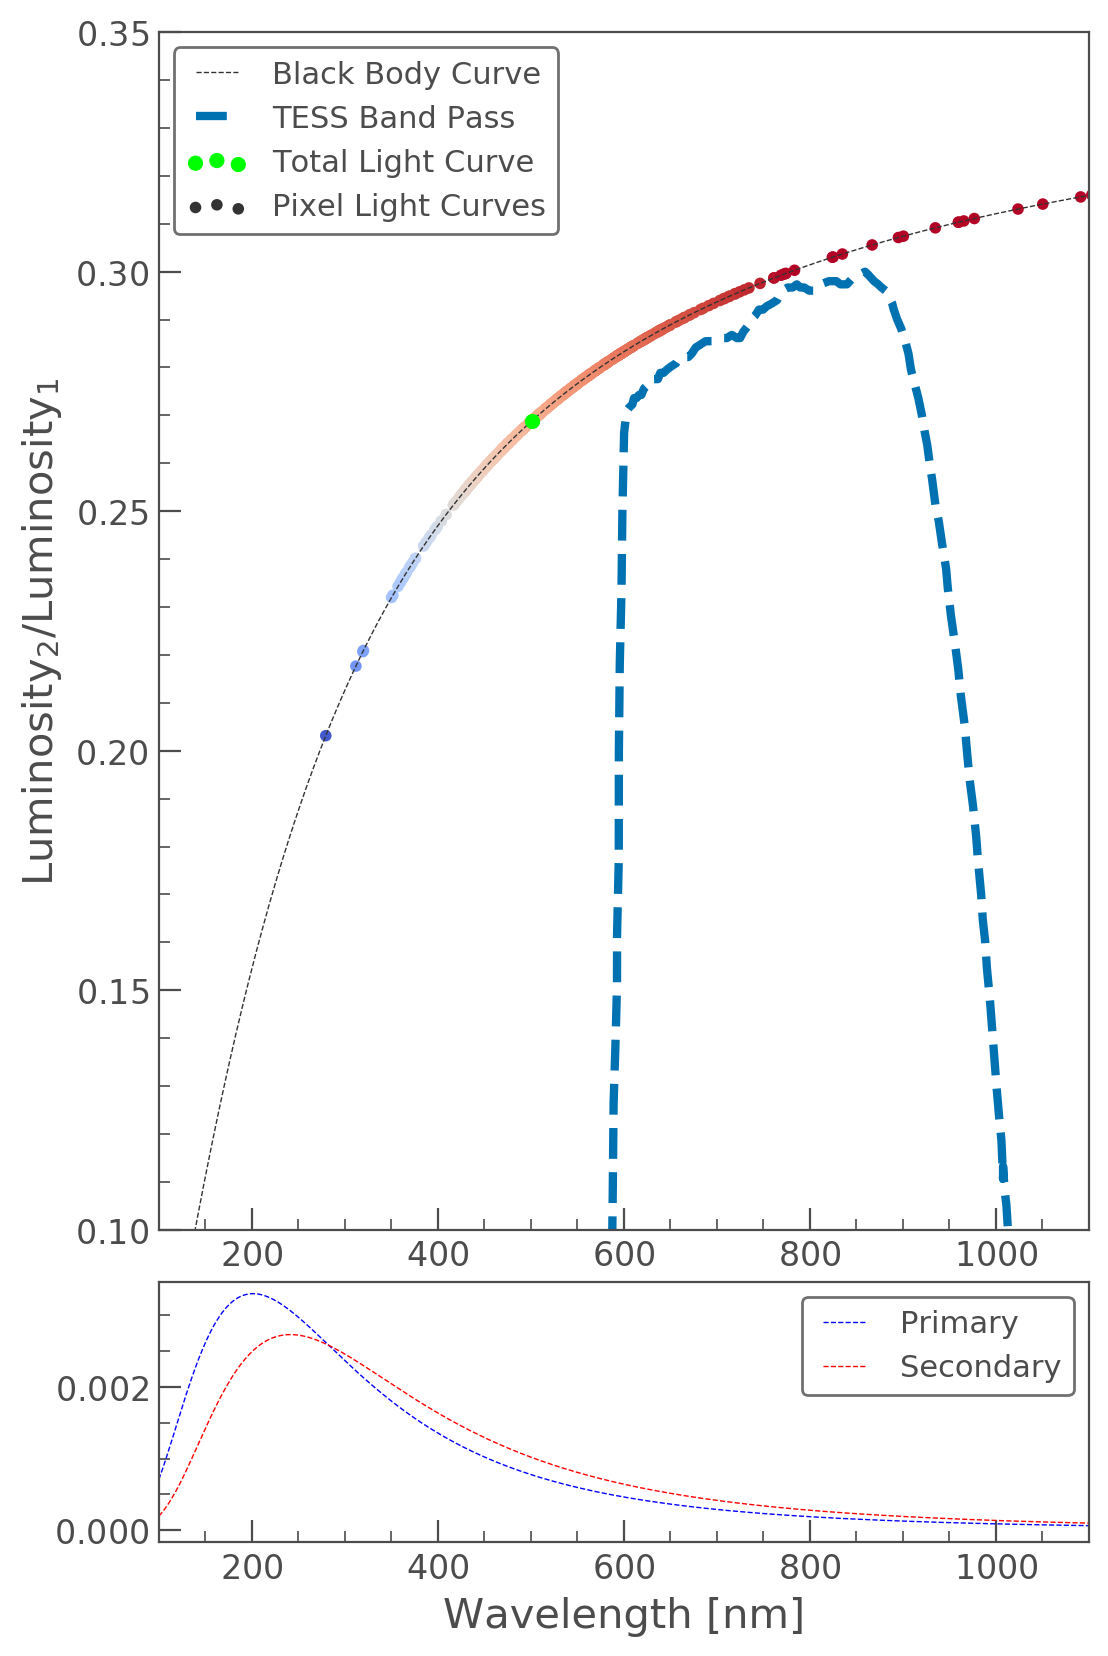

In [205]:
fig = plt.figure(figsize=(6, 10))
ax = plt.subplot2grid((5, 1), (0, 0), rowspan=4)
ax.plot(wavelength.value, (secondary_bb/primary_bb).value, ls='--', label='Black Body Curve')
ax.scatter(wav_func(result.x[1]), result.x[1], color='lime', s=20, zorder=3, label='Total Light Curve')
ax.scatter(wav_func(luminosity[aper]), luminosity[aper], c=luminosity[aper], s=10,
           label='Pixel Light Curves', cmap='coolwarm', vmin=0.2, vmax=0.3)


ax.plot(tess_bandpass[0], tess_bandpass[1]/np.nanmax(tess_bandpass[1]) * 0.3, lw=3, ls='--', label='TESS Band Pass')
ax.set_xlim(1e2, 1.1e3)
ax.set_ylim(0.1, 0.35)
ax.legend()

ax.set_ylabel('Luminosity$_2$/Luminosity$_1$')


ax = plt.subplot2grid((5, 1), (4, 0))

ax.plot(wavelength, primary_bb/np.trapz(primary_bb, wavelength.value), ls='--', c='b', label='Primary')
ax.plot(wavelength, secondary_bb/np.trapz(secondary_bb, wavelength.value), ls='--', c='r', label='Secondary')



ax.set_xlim(1e2, 1.1e3)
ax.legend()


ax.set_xlabel('Wavelength [nm]')


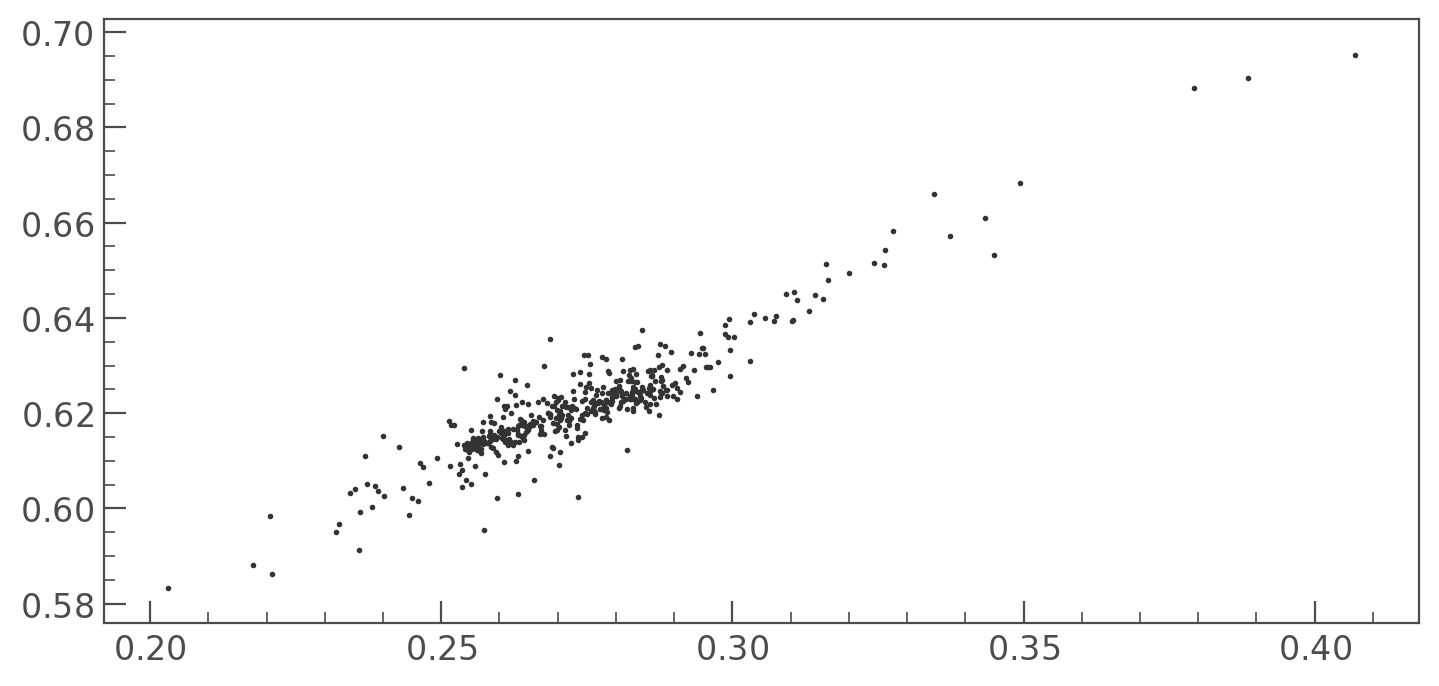

In [206]:
plt.scatter(luminosity[aper], radius[aper])